# Auto-graded section

The block below imports the necessary packages.

In [1]:
import numpy as np
import pandas as pd

In this assignment, you will work with the Dow dataset you have handled a few weeks ago. Reading and cleaning the dataset is done in the block below.

In [2]:
df = pd.read_excel('impurity_dataset-training.xlsx')

def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True
    
all_data = df[df.columns[1:]].values
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis = 1).copy().values
X_dow = np.array(all_data[real_rows, :-5], dtype = 'float')
y_dow = np.array(all_data[real_rows, -3], dtype = 'float')
y = y_dow.reshape(-1, 1)

## 1. k-Means (17.5 pts)

The k-means algorithm is an iterative type of algorithm that pursues the following expectation-maximization:

- **Expectation**: expect that the points close to the center of a cluster belong to that cluster
- **Maximization**: maximize the proximity of points to the center of a cluster by moving the center

In this problem, you will implement the k-means algorithm with several functions provided below.

In [3]:
def dist(pt1, pt2):
    return np.sqrt(sum([(xi - yi)**2 for xi, yi in zip(pt1, pt2)]))

def expected_assignment(pt, cluster_centers):
    dists = [dist(pt, ci) for ci in cluster_centers]
    min_index = dists.index(min(dists))
    return min_index

def new_centers(cluster_points, centers):
    centers = list(centers)
    for i, ci in enumerate(cluster_points):
        if ci != []:
            centers[i] = np.mean(ci, axis = 0)
    return centers

### 1a: Data Preparation (7.5 pts)

First, you need a preprocessing step to transform the given Dow dataset. Obtain a matrix named `X` as a result of the following steps:

- Standardize `X_dow` using the "standard scaler"
- Project the standardized `X_dow` onto 2-dimensional space using PCA
- Take every 5th data point

The resulting matrix should be stored as `X`.

In [4]:
########################################
# Start your code here
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(X_dow)
X_pca = PCA(n_components = 2).fit_transform(X_scaled)
X = X_pca[::5]
########################################

In [5]:
assert X.shape[1] == 2, "projection onto the wrong dimension"
assert X.shape[0] == 2060, "wrong data size"
assert np.isclose(X[:, 0].sum(), 20.5537312894985)

### 1b: One iteration of k-means (5 pts)

Making use of the functions defined above, apply the k-means algorithm **once** to the dataset and report the resulting new cluster centers in the variable `new_cluster_centers`. The initial guesses are provided below as `old_cluster_centers`, and you should keep the same data structure (e.g. a list of lists) as `new_cluster_centers`.

In [6]:
old_cluster_centers = ([0, 0], [2, 2], [30, -2])

In [7]:
########################################
# Start your code here
old_centers = np.array(old_cluster_centers)

clusters = []
for i in range(old_centers.shape[0]):
    clusters.append([])
    
for pt in X:
    cluster_idx = expected_assignment(pt, old_centers)
    clusters[cluster_idx].append(pt)
    
new_cluster_centers = new_centers(clusters, old_centers)
########################################

In [8]:
assert np.isclose(np.array(new_cluster_centers).sum(axis = 0)[0], 29.21008259)
assert np.isclose(np.array(new_cluster_centers).mean(axis = 1)[1], 2.22463995)

### 1c: Convergence of k-means (5 pts)

In this problem, you will define a function `kmeans` that implements the k-means alogrithm until the pre-defined convergence criterion is satistified. The `kmeans` function takes the following arguments:

- `X`: dataset (numpy array)
- `centers`: initial guesses for cluster centers (numpy array)
- `tol`: convergence tolerance (float, default = 0.1)

Note that the number of clusters will be implicitly defined by the number of rows in the `centers` array.

**Convergence criterion**: the maximum change in distance between cluster centers < `tol`.

Your `kmeans` function should return `new_center` (numpy array) and `clusters` (list of lists with the indices of the points in each cluster).

In [9]:
def kmeans(X, centers, tol = 0.1):
########################################
# Start your code here
    old_center = np.array(centers)
    max_dist = 1e6
    
    while max_dist > tol:
        clusters = []
        for i in range(old_center.shape[0]):
            clusters.append([])
            
        for pt in X:
            cluster_idx = expected_assignment(pt, old_center)
            clusters[cluster_idx].append(pt)
            
        new_center = new_centers(clusters, old_centers)
        
        max_dist = 0
        for i in range(old_center.shape[0]):
            dist = np.linalg.norm(old_center[i] - new_center[i])
            if max_dist < dist:
                max_dist = dist
                
        old_center = np.array(new_center)
########################################
    return np.array(new_center), clusters

In [10]:
centers, clusters = kmeans(X, np.array(old_cluster_centers))

assert type(centers) == np.ndarray, "wrong data type for centers"
assert type(clusters) == list, "wrong data type for clusters"
assert np.isclose(centers.mean(axis = 1)[2], 13.04660452), "wrong cluster centers"
assert len(clusters[0]) == 1403, "wrong clusters"

## 2. Mean Shift (17.5 pts)

The mean shift algorithm is also an iterative type of algorithm, but unlike the k-means, it is density-based rather than expectation-maximization based. You may find the functions defined below useful through this problem.

In [11]:
def get_distance(x1, x2):
    return np.linalg.norm(x1 - x2, 2)

def get_nearby_points(x, x_list, bandwidth):
    dist_pairs = []
    for i, xi in enumerate(x_list):
        dist = get_distance(x, xi)
        dist_pairs.append([dist, i, xi])
    in_window = [pt[-1] for pt in dist_pairs if pt[0] <= bandwidth]
    return in_window

def get_new_centroid(old_centroid, x_list, bandwidth):
    in_range = get_nearby_points(old_centroid, x_list, bandwidth)
    if len(in_range) == 0:
        new_centroid = old_centroid
    else:
        new_centroid = np.array(in_range).mean(axis = 0)
    return new_centroid

### 2a: One iteration of mean shift (7.5 pts)

Take `old_cluster_centers` (defined in Problem 1) as intial guesses for centroids and find a new centroids `new_centroids` using a `bandwith` of 5.

In [12]:
########################################
# Start your code here
new_centroids = []
for c in old_cluster_centers:
    new_centroids.append(get_new_centroid(c, X, 5))
########################################

In [13]:
assert np.isclose(np.array(new_centroids).sum(axis = 0)[0], 29.43546375)
assert np.isclose(np.linalg.norm(new_centroids), 30.992548441545583)

### 2b: Converging mean shift (10 pts)

A typical convergence criterion for the mean shift algorithm is checking whether old centroids and new centroids are identical to each other. Report the final centroids `final_centroids` after convergence (7.5 pts) and the number of iterations needed to reach convergence `num_iter` (2.5 pts).

In [14]:
########################################
# Start your code here
delta = 1
old_centroids = old_cluster_centers

while delta > 0:
    new_centroids = []
    for c in old_centroids:
        new_centroids.append(get_new_centroid(c, X, 5))
        
    delta = 0
    for i, c in enumerate(old_centroids):
        if delta < get_distance(c, new_centroids[i]):
            delta = 1
            
    old_centroids = new_centroids
    
final_centroids = new_centroids
########################################

In [15]:
assert np.isclose(np.array(final_centroids).sum(), 24.840886688211803)
assert np.isclose((final_centroids[1] - final_centroids[2])[0], -31.595831127643677)

In [16]:
assert np.array(old_cluster_centers * 4).sum(axis = 0)[0] == 128

## 3. Gaussian Mixture Models (15 pts)

The Gaussian Mixture Models (GMM) is a generative algorithm based on expectation-maximization. In this problem, you will play with the built-in `sklearn.mixture.GaussainMixture` object.

### 3a: Import the object (5 pts)

Import the `sklearn.mixture.GaussianMixture` object.

In [17]:
########################################
# Start your code here
from sklearn.mixture import GaussianMixture
########################################

In [18]:
assert GaussianMixture.__init__

### 3b: Silhouette score and Calinski-Harabasz score (5 pts)

Apply the GMM to `X` with the following settings and report the resulting silhouette score `sil_score` and Calinski-Harabasz score `ch_score`.

- `n_components`: 4
- `random_state`: 42
- `covariance_type`: `tied`

In [19]:
########################################
# Start your code here
gmm = GaussianMixture(n_components = 4, random_state = 42, covariance_type = 'tied')
gmm.fit(X)
y_predict = gmm.predict(X)

from sklearn.metrics import silhouette_score, calinski_harabasz_score

sil_score = silhouette_score(X, y_predict)
ch_score = calinski_harabasz_score(X, y_predict)
########################################

In [20]:
assert np.isclose(sil_score * ch_score, 5086.217116738762)

### 3c: Mixed membership (5 pts)

GMM supports mixed membership, so points have probabilites of belonging to all clusters. Find the cluster that has the second highest of probability for 101st data point in `X` (i.e. the point indexed by 100). Save the cluster label to `sec_high_cluster` and the corresponding probabiltiy `sec_high_prob`. You should assume that clusters are labeled as 1-4 (i.e. there is no cluster 0).

In [21]:
########################################
# Start your code here
prob = gmm.predict_proba(X)[100, :]
prob_copy = prob.copy()

prob.sort()
sec_high_prob = prob[-2]
sec_high_cluster = np.where(prob_copy == sec_high_prob)[0] + 1
########################################

In [22]:
assert np.isclose(sec_high_prob * sec_high_cluster, 0.005392117243474652)

# Peer-graded section

The block below imports the necessary packages.

In [24]:
import pylab as plt

In this part of the assignment, you will work with both the Dow dataset and MNIST dataset. The first dataset was loaded in the previous section. The second dataset is loaded below.

In [25]:
# MNIST Dataset
from sklearn.datasets import load_digits

digits = load_digits()

X_mnist = np.array(digits.data)
y_mnist = np.array(digits.target)

## 1. Visualizing k-Means

You will compare the custom `kmeans` function you've defined in the previous section and from the lectures to the built-in `sklearn.cluster.KMeans` function. Let's first proceed with data preprocessing.

### 1a: TSNE

Use TSNE on `X_dow` and reduce its dimensionality to 2. You may use the default hyperparameters, or select your own.

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X_dow)

/usr/local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


### 1b: Custom-coded `kmeans`

Pass the TSNE-trasnformed data and initial guess defined below to the `kmeans` function from the previous section and lectures. Plot the result of clustering by color-coding the points. Locate the cluster centers using \* markers (`marker = '*'`).

In [27]:
centers = [[5, 0], [7, 5], [100, 100], [15, 20]]

def dist(pt1, pt2):
    return np.sqrt(sum([(xi - yi)**2 for xi, yi in zip(pt1, pt2)]))

def expected_assignment(pt, cluster_centers):
    dists = [dist(pt, ci) for ci in cluster_centers]
    min_index = dists.index(min(dists))
    return min_index

def new_centers(cluster_points, centers):
    centers = list(centers)
    for i, ci in enumerate(cluster_points):
        if ci != []:
            centers[i] = np.mean(ci, axis = 0)
    return centers

def kmeans(X, centers, tol = 0.1):
    old_center = np.array(centers)
    max_dist = 1e6
    
    while max_dist > tol:
        clusters = []
        for i in range(old_center.shape[0]):
            clusters.append([])
            
        for pt in X:
            cluster_idx = expected_assignment(pt, old_center)
            clusters[cluster_idx].append(pt)
            
        new_center = new_centers(clusters, old_center)
        
        max_dist = 0
        for i in range(old_center.shape[0]):
            dist = np.linalg.norm(old_center[0] - new_center[0])
            if max_dist < dist:
                max_dist = dist
                
        old_center = np.array(new_center)
    return np.array(new_center), clusters

In [28]:
clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233', '#808080'])

In [29]:
new_center, clusters = kmeans(X_tsne, centers)

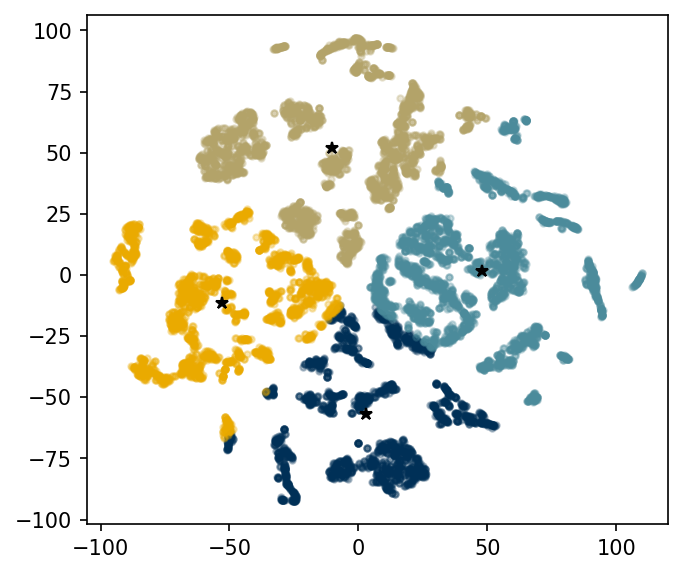

In [30]:
fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)

for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker = '.', alpha = 0.3, color = clrs[i])

for i in range(4):
    ax.plot(new_center[i][0], new_center[i][1], marker = '*', color = 'k')

### 1c: scikit-learn KMeans

Use the built-in `sklearn.cluster.KMeans` model to perform k-means clustering. Set `n_clusters` to 4. Plot the result of clustering by color-coding the points. Locate the cluster centers using \* markers (`marker = '*'`).

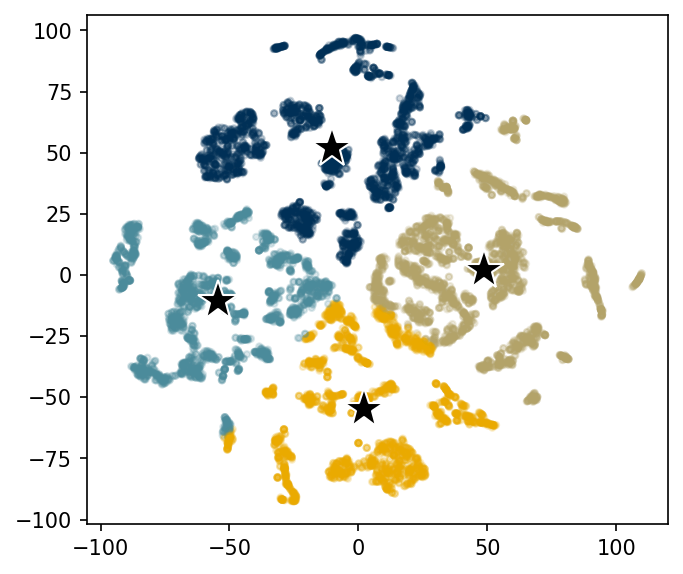

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4)
y_tsne = kmeans.fit_predict(X_tsne)
centers = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c = clrs[y_tsne], marker = '.', alpha = .2)

for center in centers:
    x_i = center[0]
    y_i = center[1]
    ax.plot(x_i, y_i, marker = '*', color = 'k', mec = 'w', markersize = 20)

### 1d: Discussion


Do the results of your implementation match the scikit-learn implementation? If not, briefly explain at least one difference that could cause the discrepancy.

**Answer**

- Our custom-coded k-means clustering uses `tol = 0.1` whereas the built-in function uses `tol = 0.0001` by default.
- The built-in k-means utilizes the different EM algorithm called the **Elkan** algorithm. ([reference](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html))

## 2. Generative Model for Handwritten Digits

In this problem, you will generate a synthetic handwritten digit derived from the MNIST dataset by kernel density estimation.

### 2a: Data selection

Choose a single number from 0 to 9 and select the points labeled as your choice in the MNIST dataset.

In [32]:
X_mnist_8 = X_mnist[y_mnist == 8]

### 2b: KDE

Train a kernel density estimation model with `sklearn.neighbors.KernelDensity` using `kernel = Gaussian` and `bandwidth = 0.35`.

In [33]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel = 'gaussian', bandwidth = 0.35)
kde.fit(X_mnist_8);

### 2c: Visualize synthetic digits

Visualize 3 examples of a synthetic digit generated by the KDE model.

In [34]:
def show_image(digit_data, n, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = digit_data[n].reshape(8,8)
    colormap = ax.imshow(img,cmap='binary',vmin=0,vmax=16)
    ax.get_figure().colorbar(colormap, ax=ax)

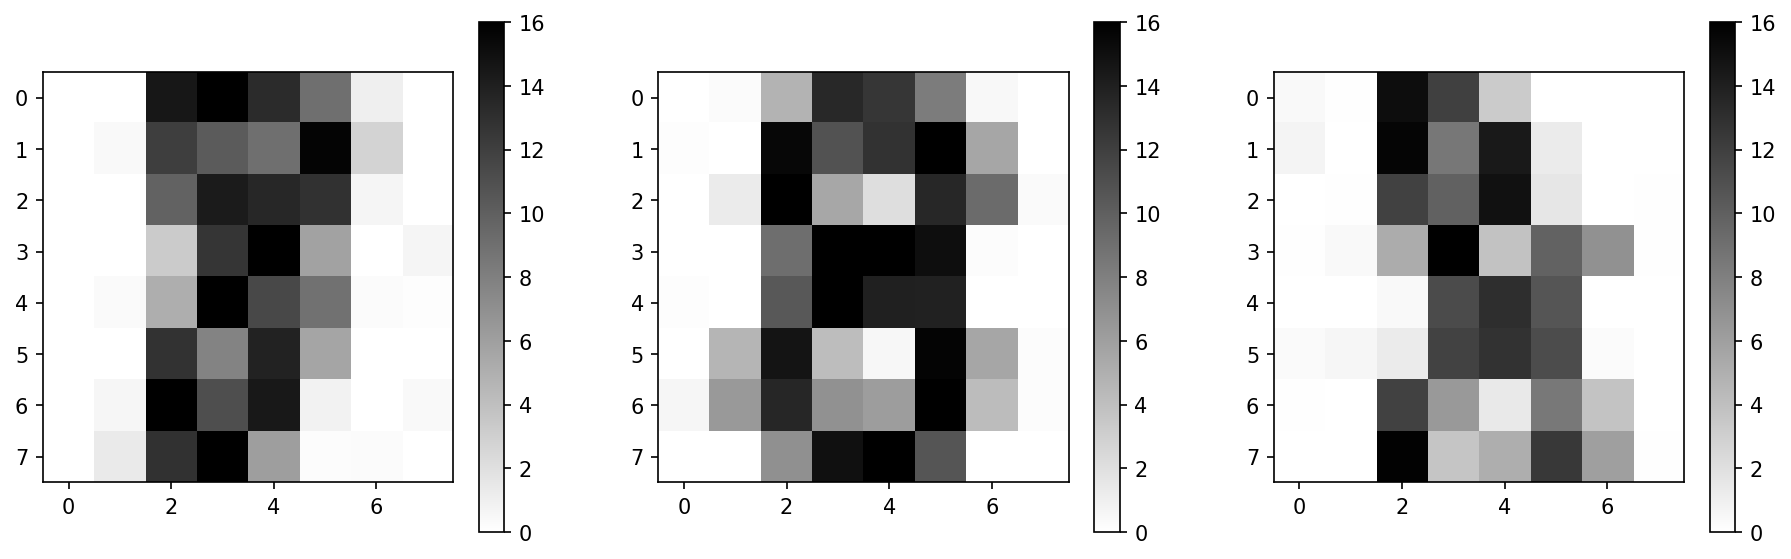

In [35]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4.5), dpi = 150)
samples = kde.sample(3)

for i, ax in enumerate(axes):
    show_image(samples, i, ax = axes[i])

## 3. GMM vs. KDE (6745 only)

The Gaussian function takes part in both GMM and KDE with `Gaussian` kernel. In a Bayesian classification scheme, which model (GMM or KDE) would you expect to perform better for the MNIST dataset? Briefly explain.

**If you are in the 4745 section, write that you are not required to answer to this question in the below block.**

KDE would perform better than GMM in a Bayesian classification scheme. In this scheme, it is important to get a very reliable class-conditional probability density functions of a finite continuous data. KDE is more flexible in terms of estimating probability density functions (PDF) since GMMs assume that the data follows a normal distribution.